DengAI - Modelos de Classificaao KNN e SVM


In [217]:
#Definir Cidade
cidade="Sobral"


In [218]:
from __future__ import division
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from matplotlib import  pyplot as plt
from sklearn.svm import SVR
from sklearn.svm import SVC
import os
import datetime
import time as time
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import cross_validate
# from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss

from sklearn.model_selection import learning_curve, GridSearchCV
#from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MaxAbsScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, log_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold
from sklearn import preprocessing
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
from statsmodels.base.model import GenericLikelihoodModel

X_train = pd.read_csv('./Dados/Sobral_Treino_Todos.csv')
X_test = pd.read_csv('./Dados/Sobral_Teste.csv')
y_train = pd.read_csv('./Dados/Sobral_Label_Todos.csv')
SubmissionFileName="./Dados/Sobral_Submission.csv"

print(X_train.head(10))
print(X_train.describe())
print(X_train.info())


# Verificar Percentual de dados faltando no dataset

total = X_train.isnull().sum().sort_values(ascending=False)
percent = (X_train.isnull().sum()/X_train.count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)


  city  Semana   Ano  Precipitacao  TempMaxima  TempMinima  Insolacao  \
0   so       1  2008          15.7       169.8       116.0       28.8   
1   so       2  2008           5.6       248.1       155.3       53.0   
2   so       3  2008          20.3       226.3       161.9       27.7   
3   so       4  2008          56.8       221.9       159.4       34.1   
4   so       5  2008          38.4       224.4       161.2       41.4   
5   so       6  2008          28.4       237.5       156.0       66.0   
6   so       7  2008          21.5       233.8       158.6       45.3   
7   so       8  2008          57.8       229.6       159.2       40.8   
8   so       9  2008           8.6       226.3       162.8       43.1   
9   so      10  2008          99.3       217.2       152.6       32.4   

   Evaporacao  TempMedia  Umidade  VelVento  
0        33.3     137.26   344.75  9.800000  
1        62.3     192.60   475.25  8.866666  
2        32.9     184.80   584.75  8.833333  
3        36.

,Total,Percent
VelVento,0,0.0
Umidade,0,0.0
TempMedia,0,0.0
Evaporacao,0,0.0
Insolacao,0,0.0
TempMinima,0,0.0
TempMaxima,0,0.0
Precipitacao,0,0.0
Ano,0,0.0
Semana,0,0.0


Não existem valor faltando no dataset.  Agora vamos verificar se há discrepâncias em nosso conjunto de dados.

Verficar quais atributos acima alteram a escala do Gráfico, após a normalização dos dados. A Precipitação altera a escala do gráfico.

In [219]:
print(X_train['Precipitacao'].describe())

count    636.000000
mean      16.280896
std       28.485045
min        0.000000
25%        0.000000
50%        0.600000
75%       22.050000
max      169.400000
Name: Precipitacao, dtype: float64


A precipitação, possui uma média de cerca de 2,30mm, enquanto o máximo é 26,19 (após a normalização). Vamos deixá-lo por um momento.

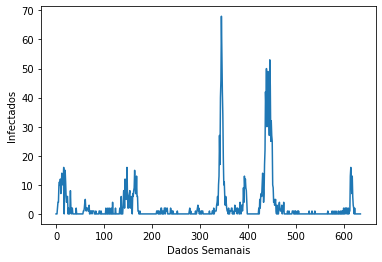

In [220]:
# Analisar dados de "Infectados" ao longo do tempo
plt.xlabel('Dados Semanais')
plt.ylabel('Infectados')
plt.plot(y_train['Infectados'])
plt.show()

# Seleção de atributos
Vamos examinar alguns atributos ao longo do tempo

Text(0.5, 0, 'Time')

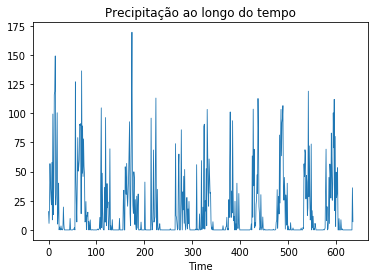

In [221]:
(X_train.Precipitacao.plot.line(lw=0.8))
plt.title('Precipitação ao longo do tempo')
plt.xlabel('Time')


Text(0.5, 0, 'Time')

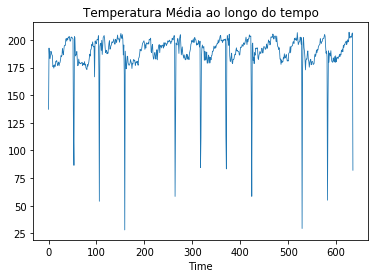

In [222]:
(X_train.TempMedia.plot.line(lw=0.8))
plt.title('Temperatura Média ao longo do tempo')
plt.xlabel('Time')


Text(0.5, 0, 'Time')

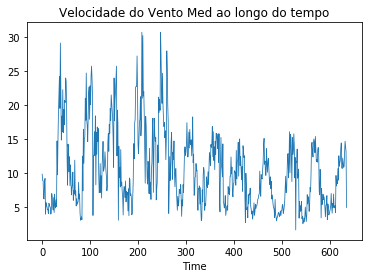

In [223]:
(X_train.VelVento.plot.line(lw=0.8))
plt.title('Velocidade do Vento Med ao longo do tempo')
plt.xlabel('Time')


Text(0.5, 0, 'Time')

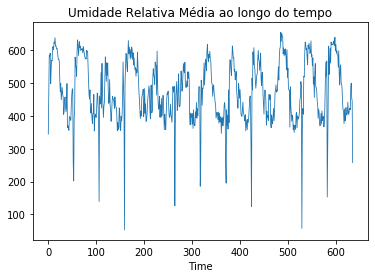

In [224]:
(X_train.Umidade.plot.line(lw=0.8))
plt.title('Umidade Relativa Média ao longo do tempo')
plt.xlabel('Time')


Nossa variável de destino, "Infectados" é um número inteiro não negativo, o que significa que estamos procurando fazer algumas previsões de contagem. As técnicas de regressão padrão para esse tipo de previsão incluem:
Regressão de Poisson
Regressão binomial negativa.

Qual técnica terá melhor desempenho depende de muitas coisas, mas a escolha entre a regressão de Poisson e a regressão binomial negativa é bastante direta.

A regressão de Poisson se ajusta de acordo com a suposição de que a média e a variância da distribuição da população são iguais. Quando não são, especificamente quando a variação é muito maior que a média, a abordagem binomial negativa é melhor.

A regressão binomial negativa simplesmente levanta a suposição de que a média e variância da população são iguais, permitindo uma classe maior de modelos possíveis. De fato, dessa perspectiva, a distribuição de Poisson é apenas um caso especial da distribuição binomial negativa.

In [225]:
print('Media e Variancia dos Infectados')
print('mean: ', y_train.mean()[2])
print('var :', y_train.var()[2])

Media e Variancia dos Infectados
mean:  2.9874213836477987
var : 61.369920269399906


Variancia maior que media sugere que a variável "Infectados" pode ser descrita por uma distribuição binomial negativa; portanto, usaremos uma regressão binomial negativa abaixo. 

Vamos analisar as Correlações


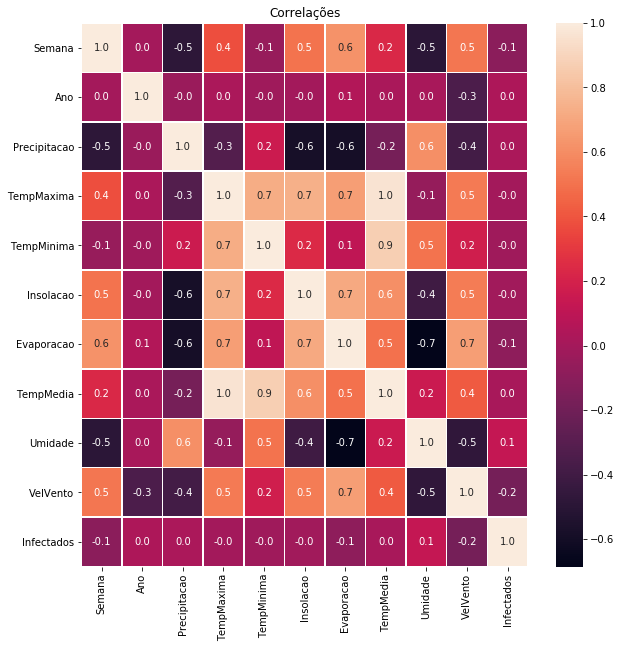

In [226]:
X_train['Infectados'] = y_train['Infectados']

f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(X_train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
ax.set_title('Correlações')
plt.show()


In [227]:
#Verifica-se que TempMaxima está fortemente relacionada com Temp_Comp_Med e Umidade_Rel_Med, 
#sugerindo que podemos excluir aluguns desses atributos.

In [228]:
delete = ['TempMinima','TempMaxima']
for z in delete:
    del X_train[z]
    del X_test[z]

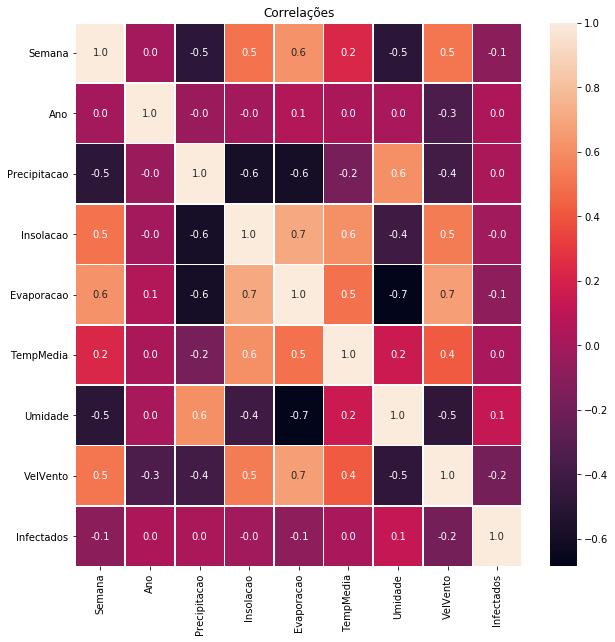

In [229]:
X_train['Infectados'] = y_train['Infectados']

f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(X_train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
ax.set_title('Correlações')
plt.show()

Text(0.5, 1.0, 'Correlações')

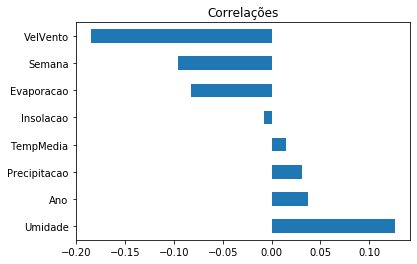

In [230]:
correlations = X_train.corr()
(correlations['Infectados'].drop('Infectados').sort_values(ascending=False).plot.barh())
plt.title('Correlações')

Portanto, temos algumas informações valiosas aqui. TempMaxima, Temp_CompMed e Umidade_Rel_Med são os atributos que estão mais fortemente correlacionados com o "Infectados".

Text(0, 0.5, 'Total de Infectados')

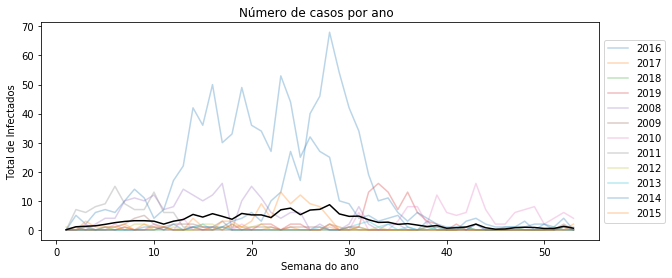

In [231]:
#Numero de Casos por semana
for i in set(y_train['Ano']):
    df = y_train[y_train['Ano'] == i]
    df.set_index('Semana', drop = True, inplace = True)
    plt.plot(df['Infectados'], alpha = .3)
    
y_train.groupby('Semana')['Infectados'].mean().plot(c = 'k', figsize = (10,4))
plt.legend(set(y_train['Ano']), loc='center left', bbox_to_anchor=(1, .5))

plt.title('Número de casos por ano  ')
plt.xlabel('Semana do ano')
plt.ylabel('Total de Infectados')

# Construindo modelos de Machine Learning

Agora que temos uma compreensão mais clara do nosso conjunto de dados, continuaremos a construir nossos modelos de ML.


In [232]:
X_train=X_train.join(X_train.groupby(['Semana'])['Infectados'].mean(), on=['Semana'], rsuffix='_avg')
X_test=X_test.join(X_train.groupby(['Semana'])['Infectados'].mean(), on=['Semana'], rsuffix='_avg')

#Vamos considerar, a principio todos os atributos
features=['Infectados','Precipitacao','Insolacao','Evaporacao','TempMedia','Umidade','VelVento']   

#TRAIN
X= X_train[features]
Y = X_train['Infectados']

#TEST
Xt= X_test[features]
X.fillna(method='bfill', inplace=True)
Xt.fillna(method='bfill', inplace=True)


In [233]:
##Criar Modelo
##train_size = 100  ##??????#

#SVM - Support Vetor Machine / SRV - Support vetor Regression
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})
t0 = time.time()
svr.fit(X,Y)

svr_fit = time.time() - t0
print("Complexidade SVR e largura de banda selecionadas e modelo ajustado em %.3f s"
      % svr_fit)
model=svr.best_estimator_
print(model)

Complexidade SVR e largura de banda selecionadas e modelo ajustado em 2.890 s
SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [234]:
#KNN 
#k_range = list(range(1, 50))

knn = KNeighborsClassifier(n_neighbors = 30)
knn.fit(X,Y)

# ----------------
# LogisticRegression
# ----------------
logreg = LogisticRegression()
logreg.fit(X, Y)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [235]:
#datasets = [X_train,  y_train ,X_test, ]

#Criação de previsao a partir dos dados de treino (7data sice0%)
train_subtrain = X_train.sample(frac=0.7)
train_subtest = X_train.loc[~X_train.index.isin(train_subtrain.index)]

train_subtrain.fillna(method='bfill', inplace=True)
train_subtest.fillna(method='bfill', inplace=True)

#X_train.describe()
train_subtest.describe()
print(train_subtest)

    city  Semana   Ano  Precipitacao  Insolacao  Evaporacao  TempMedia  \
3     so       4  2008         56.80       34.1       36.70     182.88   
8     so       9  2008          8.60       43.1       23.00     185.92   
10    so      11  2008         13.10       40.2       13.10     176.64   
18    so      19  2008        100.40       44.9       10.00     178.86   
19    so      20  2008          5.00       29.6       12.30     176.88   
..   ...     ...   ...           ...        ...         ...        ...   
624   so      42  2019          0.00       62.9       57.54     200.16   
627   so      45  2019          0.00       65.6       57.54     206.94   
628   so      46  2019          0.00       66.9       57.54     201.90   
634   so      52  2019         36.10       61.0       57.54     206.30   
635   so      53  2019          7.05       11.8       24.66      82.08   

     Umidade   VelVento  Infectados  Infectados_avg  
3     582.75   6.200001           2        1.416667  
8  

In [236]:
#create preds
preds= model.predict(train_subtest[features]).astype(int)
#SVM
#add to the dataframes
train_subtest['fitted'] = preds

# KNN
preds2 = knn.predict(train_subtest[features]).astype(int)
train_subtest['fitted2'] = preds2
#train_subtest.index = train_subtest['week_start_date']

# Logistic regression
preds3 = logreg.predict(train_subtest[features]).astype(int)
train_subtest['fitted3'] = preds3
#train_subtest.index = train_subtest['week_start_date']


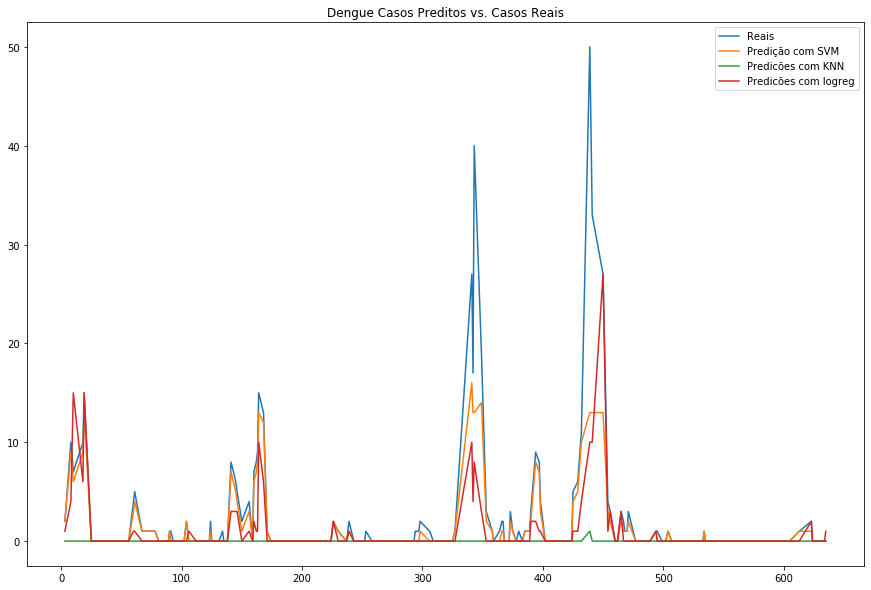

In [237]:
## Plotagem com parte de dados de treino (70%)
plt.figure(figsize=(15,10))
train_subtest.Infectados.plot(label="Reais")
train_subtest.fitted.plot( label="Predição com SVM")
train_subtest.fitted2.plot( label="Predicões com KNN")
train_subtest.fitted3.plot( label="Predicões com logreg")
plt.title("Dengue Casos Preditos vs. Casos Reais")
plt.legend()


In [247]:
scores = cross_val_score(knn, X,Y, cv=5, scoring = "accuracy")
print("Scores usando KNN:", scores)
print("Média  usando KNN:", scores.mean())

Scores usando KNN: [0.578125   0.578125   0.5625     0.578125   0.578125   0.5625
 0.57142857 0.57142857 0.57142857 0.53968254]
Média  usando KNN: 0.5691468253968253


In [248]:
scores = cross_val_score(logreg, X,Y, cv=5, scoring = "accuracy")
print("Scores usando Reg. Logística:", scores)
print("Média usando Reg. Logística:", scores.mean())

Scores usando Reg. Logística: [0.625      0.59375    0.59375    0.59375    0.59375    0.578125
 0.55555556 0.58730159 0.58730159 0.6031746 ]
Média usando Reg. Logística: 0.5911458333333333


In [249]:
#Predição KNN
submission = pd.read_csv(SubmissionFileName,index_col=[0, 1])

knn.fit(X,Y)
predictions = knn.predict(Xt).astype(int)

#pred_df = pd.DataFrame(data=predictions)
#compara=np.concatenate((submission, pred_df), axis=1)
#compara_df=pd.DataFrame(data=compara)
#compara_df.to_csv("knnCompara.csv")
#print(compara_df)

submission.Infectados = np.concatenate([predictions])
submission.to_csv("./Dados/knn.csv")


In [250]:
#Predição SVM

submission2 = pd.read_csv(SubmissionFileName,
                         index_col=[0, 1])
model.fit(X,Y)
predictions2 = model.predict(Xt).astype(int)

submission2.Infectados = np.concatenate([predictions2])
submission2.to_csv("./Dados/svm.csv")

In [251]:
#Predição Logist Regression
submission3 = pd.read_csv(SubmissionFileName,
                         index_col=[0, 1])

logreg.fit(X,Y)
predictions3 = logreg.predict(Xt).astype(int)

submission3.Infectados = np.concatenate([predictions3])
submission3.to_csv("./Dados/logreg.csv")

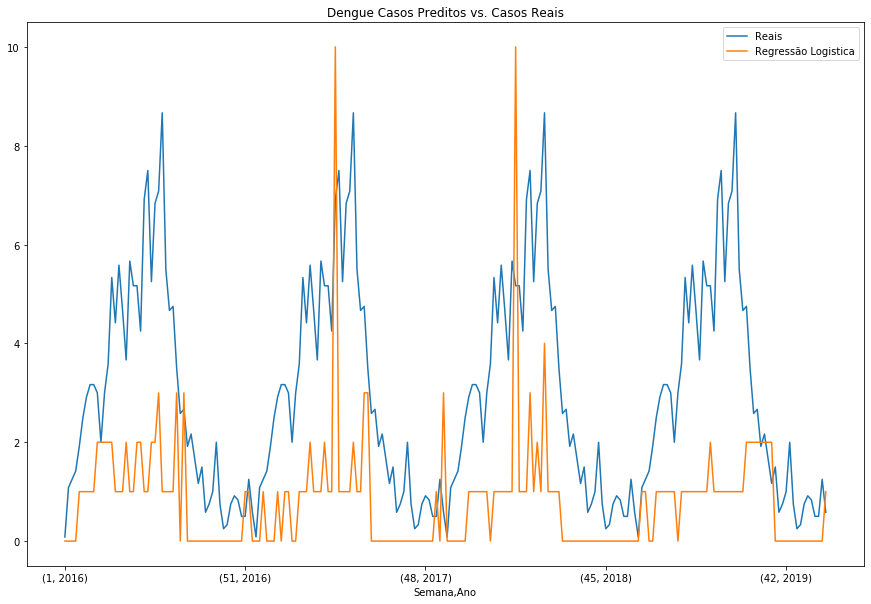

In [252]:
#Predição com Regressão logística

plt.figure(figsize=(15,10))
X_test.Infectados.plot(label="Reais")

submission3.Infectados.plot( label="Regressão Logistica")
plt.title("Dengue Casos Preditos vs. Casos Reais")
plt.legend()

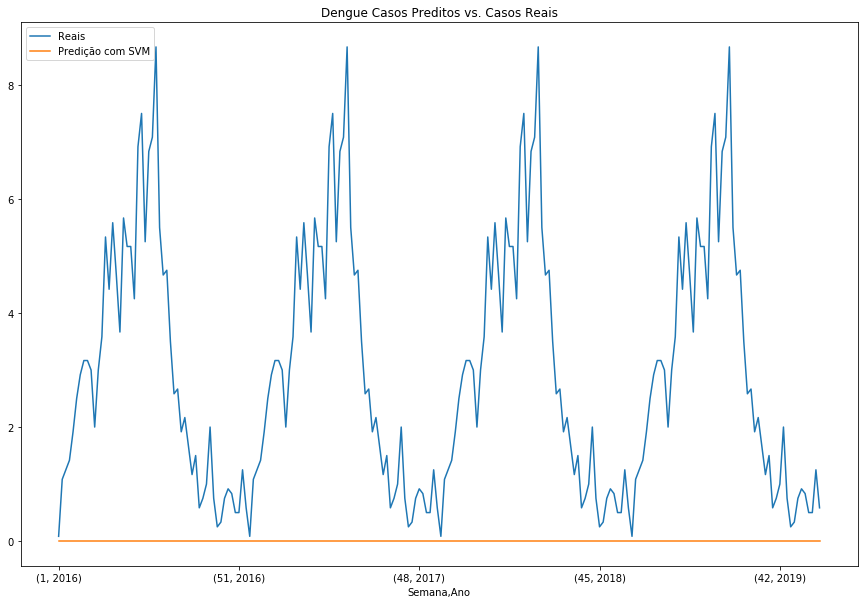

In [253]:
#Predição com SVM
plt.figure(figsize=(15,10))
X_test.Infectados.plot(label="Reais")
submission.Infectados.plot( label="Predição com SVM")
plt.title("Dengue Casos Preditos vs. Casos Reais")
plt.legend()

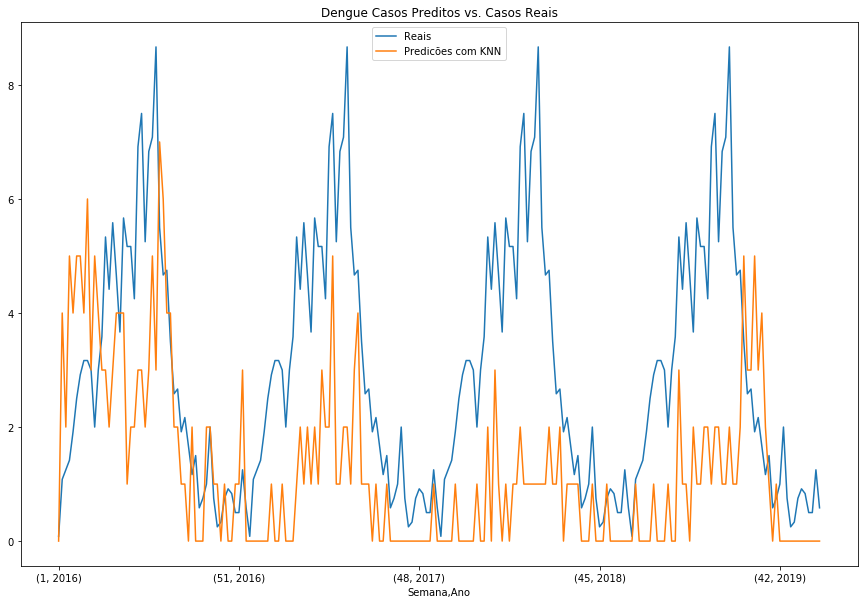

In [254]:
#Predição com KNN

plt.figure(figsize=(15,10))
X_test.Infectados.plot(label="Reais")

submission2.Infectados.plot( label="Predicões com KNN")

plt.title("Dengue Casos Preditos vs. Casos Reais")
plt.legend()